In [1]:
import math
import time
from collections import Counter
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader as TorchDataLoader
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset
from transformers import AutoTokenizer
torch.cuda.set_per_process_memory_fraction(0.9, device=0)  # 设为总显存的
from torch.optim import Adam
import os
import matplotlib.pyplot as plt
import re
import sys
sys.path.append("../model")  # 添加 model 目录到系统路径

from model import Transformer

## Configuration

In [2]:
# GPU device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model parameter setting
batch_size = 16
max_len = 256
d_model = 512
n_layers = 6
n_heads = 8
ffn_hidden = 2048
drop_prob = 0.1

# optimizer parameter setting
init_lr = 3e-5
factor = 0.9
adam_eps = 5e-9
patience = 10
warmup = 5
epoch = 100
clip = 1.0
weight_decay = 5e-4
inf = float('inf')

## Util

### [BLEU](https://aclanthology.org/P02-1040.pdf) 

In [3]:
def bleu_stats(hypothesis, reference):
    """计算BLEU所需的统计数据。"""
    stats = []
    # 添加假设（预测）和参考（真实）句子的长度
    stats.append(len(hypothesis))
    stats.append(len(reference))
    
    # 计算1-gram到4-gram的匹配统计信息
    for n in range(1, 5):
        # 统计假设句子中的n-gram
        s_ngrams = Counter(
            [tuple(hypothesis[i:i + n]) for i in range(len(hypothesis) + 1 - n)]
        )
        # 统计参考句子中的n-gram
        r_ngrams = Counter(
            [tuple(reference[i:i + n]) for i in range(len(reference) + 1 - n)]
        )
        
        # 统计假设和参考中重叠的n-gram数量
        stats.append(max([sum((s_ngrams & r_ngrams).values()), 0]))
        # 统计假设中n-gram的总数
        stats.append(max([len(hypothesis) + 1 - n, 0]))
    return stats


def bleu(stats):
    """改进版，根据n-gram统计信息计算BLEU分数（带平滑）"""
    (c, r) = stats[:2]

    if c == 0:
        return 0  # 预测为空，BLEU直接返回0
    
    # 计算log精度（每个n-gram的匹配比例取对数再求平均，加平滑避免0）
    log_bleu_prec = 0
    for x, y in zip(stats[2::2], stats[3::2]):
        if x == 0:
            log_bleu_prec += math.log(1e-9)  # 平滑处理
        else:
            log_bleu_prec += math.log(float(x) / y)
    log_bleu_prec /= 4.0
    
    # 计算最终BLEU（包括brevity penalty（简短惩罚））
    return math.exp(min([0, 1 - float(r) / c]) + log_bleu_prec)

def get_bleu(hypotheses, reference):
    """计算验证集（dev set）的BLEU分数。"""
    # 初始化统计信息（10个元素分别对应BLEU所需的各类统计数据）
    stats = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    
    # 对每个预测-参考对进行统计并累加
    for hyp, ref in zip(hypotheses, reference):
        stats += np.array(bleu_stats(hyp, ref))
    
    # 计算BLEU分数，并将结果扩大为百分制
    return 100 * bleu(stats)


def idx_to_word(x, tokenizer):
    """将索引序列转换为单词字符串（过滤特殊token，并拼接subword）"""
    tokens = []
    
    for i in x:
        word = tokenizer.convert_ids_to_tokens(int(i))
        
        # 跳过特殊token（pad、bos、eos等）
        if word in tokenizer.all_special_tokens:
            continue
        
        tokens.append(word)

    # 将subword拼成正常句子
    sentence = tokenizer.convert_tokens_to_string(tokens)
    return sentence

### Data Loader

In [4]:
class DataLoader:
    def __init__(self, ext, init_token='<bos>', eos_token='<eos>'):
        self.ext = ext
        self.SRC_LANGUAGE, self.TGT_LANGUAGE = ext
        self.init_token = init_token
        self.eos_token = eos_token

        # 使用transformers的tokenizer
        self.tokenizer = {
            '.de': AutoTokenizer.from_pretrained('bert-base-german-cased'),
            '.en': AutoTokenizer.from_pretrained('bert-base-uncased')
        }

        # 添加BOS和EOS特殊标记
        self.tokenizer['.de'].add_special_tokens({'bos_token': init_token, 'eos_token': eos_token})
        self.tokenizer['.en'].add_special_tokens({'bos_token': init_token, 'eos_token': eos_token})

        # 词汇表（实际上huggingface tokenizer就是vocab）
        self.vocab = {
            '.de': self.tokenizer['.de'],
            '.en': self.tokenizer['.en']
        }

        print('dataset initializing start')

    def get_dataset_name(self):
        """获取标准化后的数据集名称"""
        src = self.SRC_LANGUAGE[1:]
        tgt = self.TGT_LANGUAGE[1:]
        return f"iwslt2017-{src}-{tgt}"

    def make_dataset(self, train_size=None, valid_size=None, test_size=None):
        """下载并加载iwslt2017数据集，并支持可选的样本裁剪"""
        dataset_name = self.get_dataset_name()
    
        train_data = load_dataset("iwslt2017", dataset_name, split="train", trust_remote_code=True)
        valid_data = load_dataset("iwslt2017", dataset_name, split="validation", trust_remote_code=True)
        test_data = load_dataset("iwslt2017", dataset_name, split="test", trust_remote_code=True)
    
        # 可选裁剪
        if train_size is not None:
            train_data = train_data.select(range(train_size))
        if valid_size is not None:
            valid_data = valid_data.select(range(valid_size))
        if test_size is not None:
            test_data = test_data.select(range(test_size))
    
        return train_data, valid_data, test_data

    def build_vocab(self, train_data, min_freq):
        """HuggingFace tokenizer 不需要单独构建词表，这里保持统一接口"""
        pass

    def collate_fn(self, batch):
        """批处理函数：tokenizer编码 + padding"""
        src_batch, tgt_batch = [], []

        for example in batch:
            src_text = self.init_token + " " + example["translation"][self.SRC_LANGUAGE[1:]] + " " + self.eos_token
            tgt_text = self.init_token + " " + example["translation"][self.TGT_LANGUAGE[1:]] + " " + self.eos_token

            src_ids = self.vocab[self.SRC_LANGUAGE](src_text, add_special_tokens=False)["input_ids"]
            tgt_ids = self.vocab[self.TGT_LANGUAGE](tgt_text, add_special_tokens=False)["input_ids"]

            src_batch.append(torch.tensor(src_ids, dtype=torch.long))
            tgt_batch.append(torch.tensor(tgt_ids, dtype=torch.long))

        src_batch = pad_sequence(src_batch, padding_value=self.vocab[self.SRC_LANGUAGE].pad_token_id, batch_first=True)
        tgt_batch = pad_sequence(tgt_batch, padding_value=self.vocab[self.TGT_LANGUAGE].pad_token_id, batch_first=True)

        return src_batch, tgt_batch

    def make_iter(self, train_data, valid_data, test_data, batch_size, device):
        """创建迭代器"""
        train_loader = TorchDataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=self.collate_fn)
        valid_loader = TorchDataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=self.collate_fn)
        test_loader = TorchDataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=self.collate_fn)

        print('dataset initializing done')
        return train_loader, valid_loader, test_loader


### Epoch Timer

In [5]:
def epoch_time(start_time, end_time):
    """
    计算一个epoch（轮次）的运行时间（返回分钟和秒钟）。
    """
    elapsed_time = end_time - start_time  # 计算总耗时（秒）
    elapsed_mins = int(elapsed_time / 60)  # 计算分钟数
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))  # 计算剩余的秒数
    return elapsed_mins, elapsed_secs

## Data

In [6]:
loader = DataLoader(ext=('.en', '.de'),
                    init_token='<sos>',
                    eos_token='<eos>')

# train, valid, test = loader.make_dataset(train_size=500, valid_size=100, test_size=100) 
train, valid, test = loader.make_dataset(train_size=29000, valid_size=888, test_size=1000)
loader.build_vocab(train_data=train, min_freq=2)
train_iter, valid_iter, test_iter = loader.make_iter(train, valid, test,
                                                     batch_size=batch_size,
                                                     device=device)

# 新版写法：直接使用 tokenizer 来获取 pad_id、sos_id 和词表大小
src_pad_idx = loader.vocab['.en'].pad_token_id
trg_pad_idx = loader.vocab['.de'].pad_token_id
trg_sos_idx = loader.vocab['.de'].convert_tokens_to_ids('<sos>')

enc_voc_size = len(loader.vocab['.en'])
dec_voc_size = len(loader.vocab['.de'])

dataset initializing start
dataset initializing done


## Train

In [7]:
def clear_dir(path):
    """清空目录下的所有文件和文件夹，但保留目录本身"""
    if os.path.exists(path):
        for file in os.listdir(path):
            file_path = os.path.join(path, file)
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # 删除文件或符号链接
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # 删除子文件夹
    else:
        os.makedirs(path)  # 如果目录不存在，则创建

# 统计模型中可训练参数的总数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# 初始化权重（仅对有 weight 参数且维度大于1的层应用 Kaiming 初始化）
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.kaiming_uniform_(m.weight.data)


# 初始化 Transformer 模型并传入相应超参数
model = Transformer(src_pad_idx=src_pad_idx,
                    trg_pad_idx=trg_pad_idx,
                    trg_sos_idx=trg_sos_idx,
                    d_model=d_model,
                    enc_voc_size=enc_voc_size,
                    dec_voc_size=dec_voc_size,
                    max_len=max_len,
                    ffn_hidden=ffn_hidden,
                    n_head=n_heads,
                    n_layers=n_layers,
                    drop_prob=drop_prob,
                    device=device).to(device)

# 打印模型的可训练参数数量
print(f'该模型共有 {count_parameters(model):,} 个可训练参数')

# 对模型应用权重初始化
model.apply(initialize_weights)

# 定义优化器（使用 Adam 优化器）
optimizer = Adam(params=model.parameters(),
                 lr=init_lr,
                 weight_decay=weight_decay,
                 eps=adam_eps)

# 定义学习率调度器（在验证损失停止下降时，自动降低学习率）
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 factor=factor,
                                                 patience=patience)

# 定义损失函数（忽略填充标记的损失计算）
criterion = nn.CrossEntropyLoss(ignore_index=src_pad_idx)


# 训练函数
def train(model, iterator, optimizer, criterion, clip):
    model.train()  # 切换到训练模式
    epoch_loss = 0

    for i, (src, trg) in enumerate(iterator):
        src = src.to(device)  # 将源数据送入设备
        trg = trg.to(device)  # 将目标数据送入设备

        optimizer.zero_grad()  # 梯度清零

        # 模型前向传播，目标序列去掉最后一个 token
        output = model(src, trg[:, :-1])

        # 调整输出形状以便计算损失
        output_reshape = output.contiguous().view(-1, output.shape[-1])
        trg = trg[:, 1:].contiguous().view(-1)

        # 计算损失
        loss = criterion(output_reshape, trg)

        # 反向传播
        loss.backward()

        # 防止梯度爆炸，进行梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 更新模型参数
        optimizer.step()

        epoch_loss += loss.item()

        # 打印当前步骤的训练进度和损失
        print('step :', round((i / len(iterator)) * 100, 2), '% , loss :', loss.item())

    return epoch_loss / len(iterator)  # 返回平均损失


# 验证（评估）函数
def evaluate(model, iterator, criterion):
    model.eval()  # 切换到评估模式
    epoch_loss = 0
    batch_bleu = []  # 存储每个 batch 的 BLEU 分数

    with torch.no_grad():  # 禁用梯度计算
        for i, (src, trg) in enumerate(iterator):
            src = src.to(device)
            trg = trg.to(device)

            # 前向传播
            output = model(src, trg[:, :-1])

            # 调整形状用于计算损失
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg_for_bleu = trg[:, 1:] 
            trg = trg[:, 1:].contiguous().view(-1)

            # 计算损失
            loss = criterion(output_reshape, trg)
            epoch_loss += loss.item()

            # 计算 BLEU 分数
            total_bleu = []

            for j in range(batch_size):   
                try:
                    # 获取真实目标词汇（转为单词序列）
                    trg_words = idx_to_word(trg_for_bleu[j], loader.vocab[loader.TGT_LANGUAGE])

                    # 获取模型预测结果（转为单词序列）
                    output_words = output[j].max(dim=1)[1]
                    output_words = idx_to_word(output_words, loader.vocab[loader.TGT_LANGUAGE])

                    # 计算 BLEU 分数
                    bleu = get_bleu(hypotheses=output_words.split(), reference=trg_words.split())
                    total_bleu.append(bleu)
                except:
                    # 防止异常中断
                    pass

            # 计算当前 batch 的平均 BLEU 分数
            total_bleu = sum(total_bleu) / len(total_bleu)
            batch_bleu.append(total_bleu)

    # 计算所有 batch 的平均 BLEU 分数
    batch_bleu = sum(batch_bleu) / len(batch_bleu)
    return epoch_loss / len(iterator), batch_bleu


# 训练与验证的主循环
def run(total_epoch, best_loss):
    train_losses, test_losses, bleus = [], [], []  # 记录训练损失、验证损失和 BLEU 分数

    for step in range(total_epoch):
        start_time = time.time()

        # 训练一个 epoch
        train_loss = train(model, train_iter, optimizer, criterion, clip)

        # 验证模型性能
        valid_loss, bleu = evaluate(model, valid_iter, criterion)
        end_time = time.time()

        # 如果已经过了 warmup 阶段，根据验证损失调整学习率
        if step > warmup:
            scheduler.step(valid_loss)

        # 保存每个 epoch 的结果
        train_losses.append(train_loss)
        test_losses.append(valid_loss)
        bleus.append(bleu)

        # 计算本 epoch 的时间
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # 如果验证损失优于之前最佳损失，保存模型
        if valid_loss < best_loss:
            best_loss = valid_loss
            os.makedirs("saved", exist_ok=True) 
            clear_dir("saved")
            torch.save(model.state_dict(), 'saved/model-{0}.pt'.format(valid_loss))

        os.makedirs("result", exist_ok=True) 
        clear_dir("result")
        # 将训练损失、BLEU 分数和验证损失写入文件，便于可视化与后续分析
        f = open('result/train_loss.txt', 'w')
        f.write(str(train_losses))
        f.close()

        f = open('result/bleu.txt', 'w')
        f.write(str(bleus))
        f.close()

        f = open('result/test_loss.txt', 'w')
        f.write(str(test_losses))
        f.close()

        # 打印本 epoch 的训练与验证结果
        print(f'Epoch: {step + 1} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')  # 训练损失与困惑度
        print(f'\tVal Loss: {valid_loss:.3f} |  Val PPL: {math.exp(valid_loss):7.3f}')  # 验证损失与困惑度
        print(f'\tBLEU Score: {bleu:.3f}')  # 验证集 BLEU 分数


该模型共有 90,518,834 个可训练参数


In [8]:
# run(total_epoch=epoch, best_loss=inf)

## Graph

In [9]:
def read(name):
    f = open(name, 'r')
    file = f.read()
    file = re.sub('\\[', '', file)
    file = re.sub('\\]', '', file)
    f.close()

    return [float(i) for idx, i in enumerate(file.split(','))]


def draw(mode):
    if mode == 'loss':
        train = read('./result/train_loss.txt')
        test = read('./result/test_loss.txt')
        plt.plot(train, 'r', label='train')
        plt.plot(test, 'b', label='validation')
        plt.legend(loc='lower left')


    elif mode == 'bleu':
        bleu = read('./result/bleu.txt')
        plt.plot(bleu, 'b', label='bleu score')
        plt.legend(loc='lower right')

    plt.xlabel('epoch')
    plt.ylabel(mode)
    plt.title('training result')
    plt.grid(True, which='both', axis='both')
    plt.show()

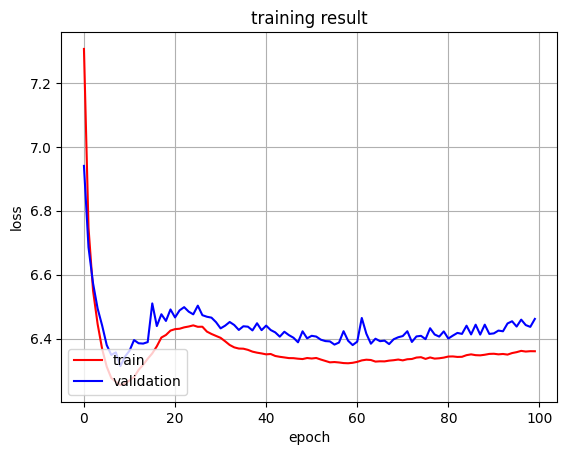

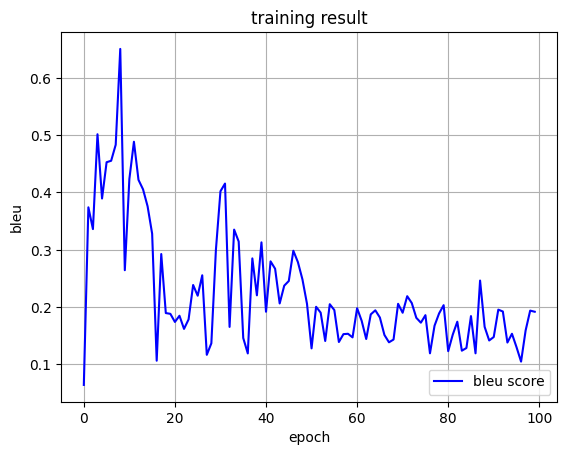

In [10]:
draw(mode='loss')
draw(mode='bleu')